In [1]:
import os
import shutil


male_path = r'C:\Users\pc\Desktop\male\\'
female_path = r'C:\Users\pc\Desktop\female\\'
test_path = r'C:\Users\pc\Desktop\test\\'
train_path = r'C:\Users\pc\Desktop\train\\'



train_size = 0.8
i=0
male_files = os.listdir(male_path)
for file_name in male_files:
    i += 1
    full_file_name = os.path.join(male_path, file_name)
    print(len(male_files))
    print(file_name)
    print(male_path + file_name)
    if  i<=(len(male_files)*train_size):
        new_name = train_path +'male.' + str(i) + '.jpg'
        os.rename(full_file_name, new_name,)
    else:
        shutil.copy(full_file_name, test_path)
        os.remove(full_file_name)
i = 0
test_size = 0.2
female_files = os.listdir(female_path)
for female_name in female_files:
    i += 1
    full_female_name = os.path.join(female_path,female_name)
    if i <=(len(female_files)*test_size):
        shutil.move(full_female_name,test_path)
    else:
        shutil.move(full_female_name,train_path)

In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16

print(tf.__version__)
print(tf.executing_eagerly())

2.3.0
True


## Функции загрузки данных

In [2]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('C:/Users/pc/Desktop/train/*.jpg')
test_files = glob('C:/Users/pc/Desktop/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('male') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

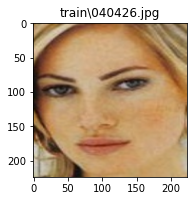

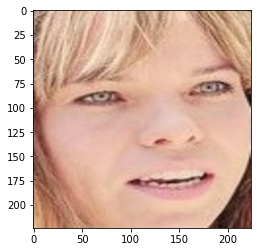

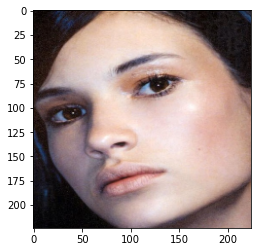

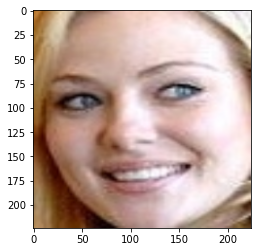

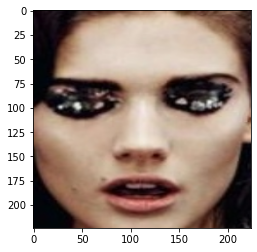

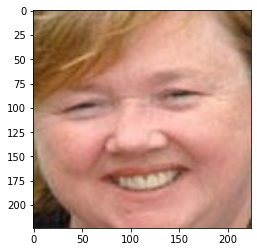

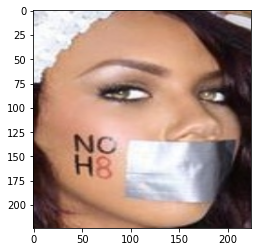

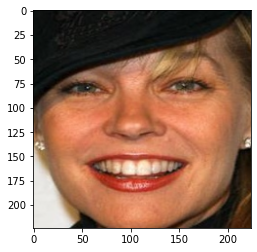

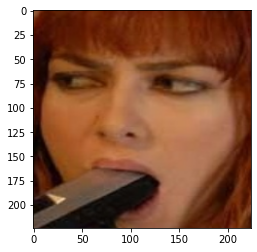

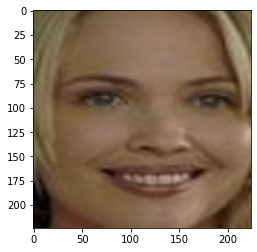

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)
    plt.show()

## Загружаем предобученную модель

In [4]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [9]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Добавляем полносвязный слой

In [5]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.compat.v1.keras.layers.BatchNormalization(
    axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
    beta_initializer='zeros', gamma_initializer='ones',
    moving_mean_initializer='zeros', moving_variance_initializer='ones',
    beta_regularizer=None, gamma_regularizer=None, beta_constraint=None,
    gamma_constraint=None, renorm=False, renorm_clipping=None, renorm_momentum=0.99,
    fused=None, trainable=True, virtual_batch_size=None, adjustment=None, name=None,
)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

## Выводим архитектуру модели

In [6]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

## Компилируем модель и запускаем обучение

In [7]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [8]:
val_samples = 5  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=100,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/100
10/10 [==============================] - 2s 182ms/step - loss: 1.6040 - accuracy: 0.7594 - val_loss: 2.4499 - val_accuracy: 0.8000
Epoch 2/100
10/10 [==============================] - 1s 114ms/step - loss: 1.0192 - a

In [9]:
model.save('male-female.hdf5')

## Предсказания на проверочной выборке

In [10]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

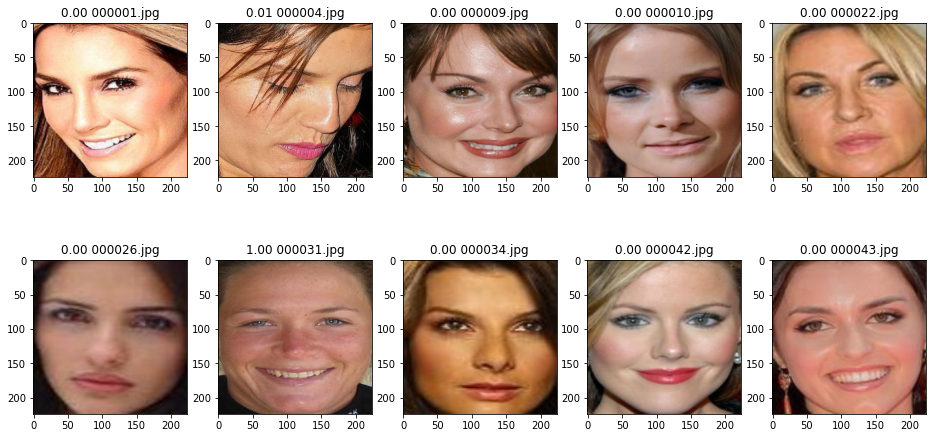

In [11]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

## Готовим данные для отправки

In [12]:
import re
# сохраняем в файл
with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

In [15]:

import pandas as pd
sub_read = pd.read_csv(r'C:\Users\pc\PycharmProjects\N_tech_lab\submit.txt')
sub_read.to_csv(r'C:\Users\pc\PycharmProjects\N_tech_lab\submit.csv',index=None,sep=',')

data = pd.read_csv(r'C:\Users\pc\PycharmProjects\N_tech_lab\submit.csv')
# Меняем значения валидационной метрики на значения male, female
test_val = []
i = 0
for val in data['label']:
    if val > 0.5:
        val = 'male'
        test_val.append(val)
    else:
        val = 'female'
        test_val.append(val)

data['label'] = test_val

id_list = []
for id in data['id']:
    id = 'img_{}.jpg'.format(id)
    id_list.append(id)
data['id']= id_list

data = data.set_index(data['id'])
data = data.drop('id',axis=1)

data.to_json(r'C:\Users\pc\PycharmProjects\N_tech_lab\process_result.json',)

                 label
id                    
img_1.jpg       female
img_4.jpg       female
img_9.jpg       female
img_10.jpg      female
img_22.jpg      female
...                ...
img_202585.jpg    male
img_202586.jpg    male
img_202588.jpg    male
img_202589.jpg    male
img_202597.jpg    male

[20001 rows x 1 columns]
